## Projeto 2

Para esse projeto, com o intuito de ter mais dados para o treinamento dos modelos, foi necessário adicionar bases dos anos de 2017 à 2019 ao conjunto do ano de 2020 que foi utilizado no projeto 1. Dessa forma, o notebook inicia carregando a base com os dados dos 4 anos agrupados e processados pelo código do projeto 1

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
main_df = pd.read_csv('acidentes_group.csv', index_col=0)

Ao comparar a distruibuição dos valores nas colunas 'tipo' e 'natureza_acidente' percebe-se que a base está bastante desbalanceada, além disso a coluna tipo possui 8 valores possíveis e está mais desbalanceada do que 'natureza_acidente' que possui apensa 3 possíveis valores. Dessa forma, escolhi 'natureza_acidente' como a coluna a ser predita.

In [75]:
main_df['tipo'].value_counts()

COLISÃO              27473
ABALROAMENTO          8224
CHOQUE                1485
ATROPELAMENTO          918
ENGAVETAMENTO          397
ACID. DE PERCURSO      149
TOMBAMENTO              98
CAPOTAMENTO             82
Name: tipo, dtype: int64

In [76]:
main_df['natureza_acidente'].value_counts()

SEM VÍTIMA      30552
COM VÍTIMA       8167
VÍTIMA FATAL      107
Name: natureza_acidente, dtype: int64

#### Usando OneHot Encoding para converter os dados categóricos

In [77]:
main_df['bairro'] = main_df['bairro'].astype('category')
main_df['bairro'] = main_df['bairro'].cat.codes
main_df['tipo'] = main_df['tipo'].astype('category')
main_df['tipo'] = main_df['tipo'].cat.codes
main_df['natureza_acidente'] = main_df['natureza_acidente'].astype('category')

In [78]:
dfDummies = pd.get_dummies(main_df['bairro'], prefix = 'bairro')
main_df = pd.concat([main_df, dfDummies], axis=1)
dfDummies2 = pd.get_dummies(main_df['tipo'], prefix = 'tipo')
main_df = pd.concat([main_df, dfDummies2], axis=1)

In [79]:
main_df.isna().sum()

natureza_acidente    0
bairro               0
tipo                 0
auto                 0
moto                 0
                    ..
tipo_3               0
tipo_4               0
tipo_5               0
tipo_6               0
tipo_7               0
Length: 116, dtype: int64

In [80]:
# Embaralhando linhas do dataset
main_df = main_df.sample(frac=1)

## Dividindo dataset em treino, teste e validação

In [81]:
X_acidentes = main_df.drop('natureza_acidente', axis=1)
y_acidentes = main_df['natureza_acidente']

Xtrain, Xtest, ytrain, ytest = train_test_split(X_acidentes, y_acidentes, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Predições
   Nas predições os modelos que utilizei foram: KNN, Árvore de Decisão, Random Forest e Gradient Boosting. 
   
   - Na seleção de hyperparamêtros para o KNN segui o exemplo usado em aula (iteração em uma lista de valores para k usando cross validation para encontrar o melhor valor do número de vizinhos). 
   - Nos demais modelos, utilizei RandomizedSearch com cross validation, o desejo era utilizar GridSearch para ter mais chances de encontrar um melhor global mas, por questões de limitação de hardware e tempo, não foi possível uma vez que o método é mais custoso. Para tentar diminuir um pouco a probabilidade de encontrar apenas um melhores locais, executei o RandomizedSearch uma vez para cada parâmetro

## KNN

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn import metrics

### Selecionando hyperparâmetro para o número de vizinhos sobre o conjunto de validação

In [83]:
k_range = range(1, 25)

k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_val, y_val, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8185447520927237, 0.7960077269800385, 0.8332260141661301, 0.8336123631680618, 0.83322601416613, 0.8352865421764328, 0.8306503541532517, 0.8368319381841598, 0.8291049581455248, 0.8342562781712815, 0.8291049581455248, 0.8325820991629105, 0.8278171281390856, 0.8282034771410174, 0.8244687701223438, 0.8269156471345782, 0.8238248551191243, 0.8275595621377978, 0.8252414681262075, 0.8260141661300707, 0.8226658081133291, 0.8224082421120412, 0.8177720540888602, 0.8198325820991629]


Text(0, 0.5, 'Cross-Validated Accuracy')

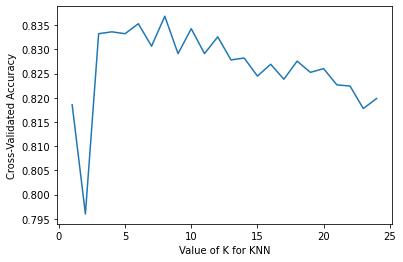

In [84]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### Treinando o modelo com o valor encontrado para K e realizando predição

In [85]:
model = KNeighborsClassifier(n_neighbors=8)

In [86]:
#desempenho no treinamento e teste
y_pred_train = model.fit(Xtrain, ytrain).predict(Xtrain)
y_pred = model.fit(Xtrain, ytrain).predict(Xtest)

print("ACC TRAINING:" + str(accuracy_score(ytrain, y_pred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, y_pred)))
print("-------------------------------------------------------")
print(metrics.classification_report(ytest, y_pred, digits=3, zero_division=0))

ACC TRAINING:0.8647456535737282
ACC TEST:0.8523049188771569
-------------------------------------------------------
              precision    recall  f1-score   support

  COM VÍTIMA      0.635     0.707     0.669      1629
  SEM VÍTIMA      0.919     0.894     0.906      6114
VÍTIMA FATAL      0.000     0.000     0.000        23

    accuracy                          0.852      7766
   macro avg      0.518     0.534     0.525      7766
weighted avg      0.856     0.852     0.854      7766



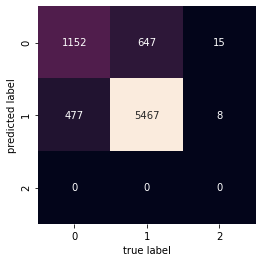

In [87]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

### Selecionando hyperparâmetros sobre o conjunto de validação com RandomizedSearch

In [89]:
random_search_cv = RandomizedSearchCV(estimator = DecisionTreeClassifier(),
                              param_distributions = {'criterion':['gini', 'entropy']},cv = 5, n_iter=2)

random_search_cv.fit(X_val,y_val)

best_criterion = random_search_cv.best_params_['criterion']
#Vamos ver informações relevantes:
print('Melhor criterion: {}'.format(best_criterion))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor criterion: gini
Desempenho do melhor modelo: 0.855


In [90]:
random_search_cv = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion=random_search_cv.best_params_['criterion']),
                              param_distributions = {'splitter':['best', 'random']},cv = 5, n_iter=2)

random_search_cv.fit(X_val,y_val)

best_splitter = random_search_cv.best_params_['splitter']
#Vamos ver informações relevantes:
print('Melhor splitter: {}'.format(best_splitter))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor splitter: best
Desempenho do melhor modelo: 0.856


In [91]:
random_search_cv = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion= best_criterion, 
                                                                         splitter=best_splitter),
                              param_distributions = {'max_depth': [5, 8, 15, 25, 30]},cv = 5, n_iter=5)

random_search_cv.fit(X_val,y_val)

tree_max_depth = random_search_cv.best_params_['max_depth']
#Vamos ver informações relevantes:
print('Melhor max_depth: {}'.format(tree_max_depth))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor max_depth: 5
Desempenho do melhor modelo: 0.861


### Treinando o modelo com os valores encontrados para os hyperparâmetros e realizando predição

In [92]:
clf_tree = DecisionTreeClassifier(criterion=best_criterion, splitter=best_splitter, max_depth=tree_max_depth)

In [93]:
clf_tree.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=5)

In [94]:
tree_pred = clf_tree.predict(Xtest)
tree_pred_train = clf_tree.predict(Xtrain)

In [95]:
print("ACC TRAINING:" + str(accuracy_score(ytrain, tree_pred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, tree_pred)))
print("-------------------------------------------------------")
print(metrics.classification_report(ytest, tree_pred, digits=3, zero_division=0))

ACC TRAINING:0.8646168705730843
ACC TEST:0.8678856554210662
-------------------------------------------------------
              precision    recall  f1-score   support

  COM VÍTIMA      0.637     0.863     0.733      1629
  SEM VÍTIMA      0.960     0.872     0.914      6114
VÍTIMA FATAL      0.000     0.000     0.000        23

    accuracy                          0.868      7766
   macro avg      0.532     0.579     0.549      7766
weighted avg      0.889     0.868     0.873      7766



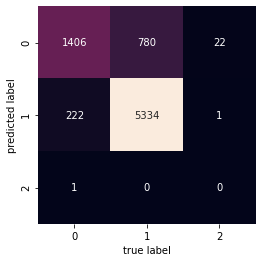

In [96]:
mat = confusion_matrix(ytest, tree_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

#### Selecionando hyperparâmetros sobre o conjunto de validação com RandomizedSearch

In [98]:
random_search_cv = RandomizedSearchCV(estimator = RandomForestClassifier(),
                              param_distributions = {'n_estimators':range(1,1000,100)},cv = 5,n_iter = 10)

random_search_cv.fit(X_val,y_val)

rf_estimators = random_search_cv.best_params_['n_estimators']

#Vamos ver informações relevantes:
print('Melhor número de estimadores: {}'.format(rf_estimators))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor número de estimadores: 201
Desempenho do melhor modelo: 0.859


In [99]:
random_search_cv = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators = rf_estimators),
                              param_distributions = {'max_depth': [5, 8, 15, 25, 30]},cv = 5, n_iter = 5)

random_search_cv.fit(X_val,y_val)

rf_max_depth = random_search_cv.best_params_['max_depth']

#Vamos ver informações relevantes:
print('Melhor max_depth: {}'.format(rf_max_depth))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor max_depth: 25
Desempenho do melhor modelo: 0.863


#### Treinando o modelo com os valores encontrados para os hyperparâmetros e realizando predição

In [100]:
model = RandomForestClassifier(n_estimators=rf_estimators, max_depth=rf_max_depth)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

In [101]:
print("ACC TRAINING:" + str(accuracy_score(ytrain, ypred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, ypred)))
print("-------------------------------------------------------")
print(metrics.classification_report(ytest, ypred, digits=3, zero_division=0))

ACC TRAINING:0.8810045074050226
ACC TEST:0.8684007210919392
-------------------------------------------------------
              precision    recall  f1-score   support

  COM VÍTIMA      0.655     0.792     0.717      1629
  SEM VÍTIMA      0.941     0.892     0.916      6114
VÍTIMA FATAL      0.000     0.000     0.000        23

    accuracy                          0.868      7766
   macro avg      0.532     0.561     0.544      7766
weighted avg      0.878     0.868     0.872      7766



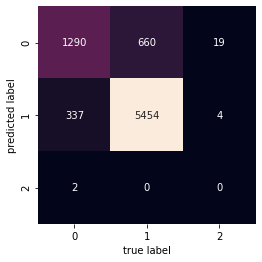

In [102]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Gradient Boosting

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

#### Selecionando hyperparâmetros sobre o conjunto de validação com RandomizedSearch

In [104]:
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(),
                              param_distributions = {'n_estimators':range(10,100,5)},cv = 3,n_iter = 10)

random_search_cv.fit(X_val,y_val)

gb_estimators = random_search_cv.best_params_['n_estimators']

#Vamos ver informações relevantes:
print('Melhor número de estimadores: {}'.format(gb_estimators))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor número de estimadores: 15
Desempenho do melhor modelo: 0.858


In [105]:
random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(n_estimators=gb_estimators),
                            param_distributions = {'max_depth':range(5,16,2)},
                            cv = 3,n_iter = 6)

random_search_cv.fit(X_val,y_val)

gb_max_depth = random_search_cv.best_params_['max_depth']
#Vamos ver informações relevantes:
print('Max depth: {}'.format(gb_max_depth))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Max depth: 5
Desempenho do melhor modelo: 0.858


#### Treinando o modelo com os valores encontrados para os hyperparâmetros e realizando predição

In [106]:
modelGB = GradientBoostingClassifier(n_estimators=gb_estimators, max_depth=gb_max_depth)
modelGB.fit(Xtrain, ytrain)

GradientBoostingClassifier(max_depth=5, n_estimators=15)

In [107]:
ypred = modelGB.predict(Xtest)
ypred_train = modelGB.predict(Xtrain)

print("ACC TRAINING:" + str(accuracy_score(ytrain, ypred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, ypred)))
print("-------------------------------------------------------")
print(metrics.classification_report(ytest, ypred, digits=3, zero_division=0))

ACC TRAINING:0.868190598840953
ACC TEST:0.8685294875096575
-------------------------------------------------------
              precision    recall  f1-score   support

  COM VÍTIMA      0.657     0.785     0.715      1629
  SEM VÍTIMA      0.941     0.894     0.917      6114
VÍTIMA FATAL      0.000     0.000     0.000        23

    accuracy                          0.869      7766
   macro avg      0.533     0.560     0.544      7766
weighted avg      0.879     0.869     0.872      7766



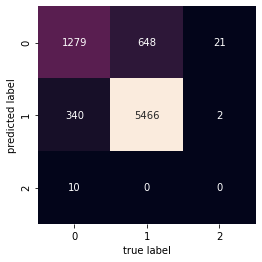

In [108]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Escolha do modelo mais eficiente

Observando as métricas resultantes de cada modelo, pode-se observar que o desempenho de todos foi bem parecido. Apesar disso, o modelo de **Árvore de Decisão** se mostrou minimamente mais eficiente se observado o f1_score e a acurária, além disso, o modelo se mostrou o de execução mais rápida.

Uma característica comum aos modelos é de que, em todos, se pode observar pela matriz de confusão que os modelos tem dificuldade para classificar entradas da classe 2 (Vitima fatal) por conta do número muito pequeno de entradas da mesma.

Para tentar contornar esse problema de balanceamento, utilizei da técnica **SMOTE**, onde são gerados novos dados para as classes minoritárias a partir dos dados já existentes dessas classes.

In [109]:
from imblearn.over_sampling import SMOTE

In [110]:
smote = SMOTE(random_state = 32)
X_smote_res, y_smote_res = smote.fit_resample(Xtrain, ytrain)

In [111]:
y_smote_res.value_counts()

COM VÍTIMA      24438
SEM VÍTIMA      24438
VÍTIMA FATAL    24438
Name: natureza_acidente, dtype: int64

In [112]:
clf_tree = DecisionTreeClassifier(criterion=best_criterion, splitter=best_splitter, max_depth=tree_max_depth)
clf_tree.fit(X_smote_res, y_smote_res)

DecisionTreeClassifier(max_depth=5)

In [113]:
tree_pred = clf_tree.predict(Xtest)
tree_pred_train = clf_tree.predict(Xtrain)

In [114]:
print("ACC TRAINING:" + str(accuracy_score(ytrain, tree_pred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, tree_pred)))
print("-------------------------------------------------------")
print(metrics.classification_report(ytest, tree_pred, digits=3, zero_division=0))

ACC TRAINING:0.8373148744365744
ACC TEST:0.8385269121813032
-------------------------------------------------------
              precision    recall  f1-score   support

  COM VÍTIMA      0.624     0.774     0.691      1629
  SEM VÍTIMA      0.963     0.857     0.907      6114
VÍTIMA FATAL      0.030     0.391     0.055        23

    accuracy                          0.839      7766
   macro avg      0.539     0.674     0.551      7766
weighted avg      0.889     0.839     0.859      7766



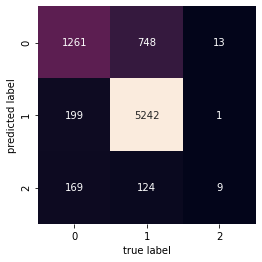

In [115]:
mat = confusion_matrix(ytest, tree_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Considerações

Como se pode observar pelos resultados do modelo utilizando a base balanceada pelo **SMOTE**, apesar de ter uma ligeira queda na acurácia, agora o modelo é capaz de identificar elementos da classe 'VÍTIMA FATAL'. 
- Um balanceamento um pouco mais refinado seria capaz de melhorar ainda mais esses resultados
- Poderia ser analisada a otimização de outros parâmentros para o melhor modelo e a possibilidade de teste com outros algoritmos não abordados no projeto.
- **MLflow**: Ao tentar utilizá-lo tive muitos problemas de execução e o computador travou várias vezes, então acabei deixando de lado, mas seria uma boa ferramenta para ajudar a encontrar novas formas de melhorar o modelo além do balanceamento.